<a href="https://colab.research.google.com/github/yhanyi/MLNotebooks/blob/main/TradingML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trading ML?
I wanted to mess around with ML in trading and stonks but the dataset I chose is kinda trash and I have exams...

### Dataset Info
Taken from Dukascopy
- USD/JPY Forex
- 4H Candlestick
- 1 Jan 2023 - 31 Dec 2023

In [1]:
import pandas as pd
raw_data = pd.read_csv("/content/USDJPY_Candlestick_4_Hour_ASK_01.01.2023-31.12.2023.csv")
raw_data.head()

,Local time,Open,High,Low,Close,Volume
0,31.12.2022 22:00:00.000 GMT+0800,131.147,131.147,131.147,131.147,0.0
1,01.01.2023 02:00:00.000 GMT+0800,131.147,131.147,131.147,131.147,0.0
2,01.01.2023 06:00:00.000 GMT+0800,131.147,131.147,131.147,131.147,0.0
3,01.01.2023 10:00:00.000 GMT+0800,131.147,131.147,131.147,131.147,0.0
4,01.01.2023 14:00:00.000 GMT+0800,131.147,131.147,131.147,131.147,0.0


In [2]:
dropZeros = raw_data[raw_data["Volume"] == 0].index
data = raw_data.drop(dropZeros)
data.isna().sum()

Local time    0
Open          0
High          0
Low           0
Close         0
Volume        0
dtype: int64

In [3]:
!pip install pandas-ta
import numpy as np
import pandas_ta as ta

In [4]:
# Average True Range
data["ATR"] = data.ta.atr(length=20)
# Relative Strength Index
data["RSI"] = data.ta.rsi()
# Average Price
data["AVG"] = data.ta.midprice(length=1)
# Simple Moving Average 40
data["SMA40"] = data.ta.sma(length=40)
# Simple Moving Average 80
data["SMA80"] = data.ta.sma(length=80)
# Simple Moving Average 160
data["SMA160"] = data.ta.sma(length=160)

In [5]:
data.ta.indicators()

Pandas TA - Technical Analysis Indicators - v0.3.14b0
Total Indicators & Utilities: 205
Abbreviations:
    aberration, above, above_value, accbands, ad, adosc, adx, alma, amat, ao, aobv, apo, aroon, atr, bbands, below, below_value, bias, bop, brar, cci, cdl_pattern, cdl_z, cfo, cg, chop, cksp, cmf, cmo, coppock, cross, cross_value, cti, decay, decreasing, dema, dm, donchian, dpo, ebsw, efi, ema, entropy, eom, er, eri, fisher, fwma, ha, hilo, hl2, hlc3, hma, hwc, hwma, ichimoku, increasing, inertia, jma, kama, kc, kdj, kst, kurtosis, kvo, linreg, log_return, long_run, macd, mad, massi, mcgd, median, mfi, midpoint, midprice, mom, natr, nvi, obv, ohlc4, pdist, percent_return, pgo, ppo, psar, psl, pvi, pvo, pvol, pvr, pvt, pwma, qqe, qstick, quantile, rma, roc, rsi, rsx, rvgi, rvi, short_run, sinwma, skew, slope, sma, smi, squeeze, squeeze_pro, ssf, stc, stdev, stoch, stochrsi, supertrend, swma, t3, td_seq, tema, thermo, tos_stdevall, trima, trix, true_range, tsi, tsignals, ttm_trend, ui, 

In [6]:
from scipy.stats import linregress
def getSlope(array):
  y = np.array(array)
  x = np.arange(len(y))
  slope, intercept, r_value, p_value, std = linregress(x,y)
  return slope

# Last 5 values of each feature to calculate the slope
backrollingValue = 5

data["SlopeSMA40"] = data["SMA40"].rolling(window=backrollingValue).apply(getSlope, raw=True)
data["SlopeSMA80"] = data["SMA80"].rolling(window=backrollingValue).apply(getSlope, raw=True)
data["SlopeSMA160"] = data["SMA160"].rolling(window=backrollingValue).apply(getSlope, raw=True)
data["SlopeAVG"] = data["AVG"].rolling(window=backrollingValue).apply(getSlope, raw=True)
data["SlopeRSI"] = data["RSI"].rolling(window=backrollingValue).apply(getSlope, raw=True)
data.head()

,Local time,Open,High,Low,Close,Volume,ATR,RSI,AVG,SMA40,SMA80,SMA160,SlopeSMA40,SlopeSMA80,SlopeSMA160,SlopeAVG,SlopeRSI
8,02.01.2023 06:00:00.000 GMT+0800,131.001,131.061,130.823,131.010,3534.4000,NaN,NaN,130.9420,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,02.01.2023 10:00:00.000 GMT+0800,131.010,131.101,130.912,130.971,7421.4601,NaN,NaN,131.0065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,02.01.2023 14:00:00.000 GMT+0800,130.951,131.032,130.868,130.891,20151.6495,NaN,NaN,130.9500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,02.01.2023 18:00:00.000 GMT+0800,130.894,130.930,130.636,130.662,27922.9302,NaN,NaN,130.7830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,02.01.2023 22:00:00.000 GMT+0800,130.663,130.863,130.650,130.798,125336.4883,NaN,NaN,130.7565,NaN,NaN,NaN,NaN,NaN,NaN,-0.05945,NaN


### Target Categories

In [10]:
pipdiff = 500*1e-5
SLTPRatio = 2 # pipDiff/Ratio = SL
def getTarget(bars, data):
    length = len(data)
    high = list(data['High'])
    low = list(data['Low'])
    close = list(data['Close'])
    open = list(data['Open'])
    trend = [None] * length

    for line in range (0,length-bars-2):
        valueOpenLow = 0
        valueOpenHigh = 0
        for i in range(1,bars+2):
            value1 = open[line+1]-low[line+i]
            value2 = open[line+1]-high[line+i]
            valueOpenLow = max(value1, valueOpenLow)
            valueOpenHigh = min(value2, valueOpenHigh)

            if valueOpenLow >= pipdiff and -valueOpenHigh <= pipdiff/SLTPRatio:
                trend[line] = 1 # Downtrend
            elif valueOpenLow <= pipdiff/SLTPRatio and -valueOpenHigh >= pipdiff:
                trend[line] = 2 # Uptrend
            else:
                trend[line] = 0 # Unclear

    return trend

data["Target"] = getTarget(16, data)
data.head()

,Local time,Open,High,Low,Close,Volume,ATR,RSI,AVG,SMA40,SMA80,SMA160,SlopeSMA40,SlopeSMA80,SlopeSMA160,SlopeAVG,SlopeRSI,Target
8,02.01.2023 06:00:00.000 GMT+0800,131.001,131.061,130.823,131.010,3534.4000,NaN,NaN,130.9420,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
9,02.01.2023 10:00:00.000 GMT+0800,131.010,131.101,130.912,130.971,7421.4601,NaN,NaN,131.0065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
10,02.01.2023 14:00:00.000 GMT+0800,130.951,131.032,130.868,130.891,20151.6495,NaN,NaN,130.9500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
11,02.01.2023 18:00:00.000 GMT+0800,130.894,130.930,130.636,130.662,27922.9302,NaN,NaN,130.7830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
12,02.01.2023 22:00:00.000 GMT+0800,130.663,130.863,130.650,130.798,125336.4883,NaN,NaN,130.7565,NaN,NaN,NaN,NaN,NaN,NaN,-0.05945,NaN,0.0


### Quick Analysis

<ipython-input-11-f64b1cae0baa>:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data_model.hist(ax=ax)


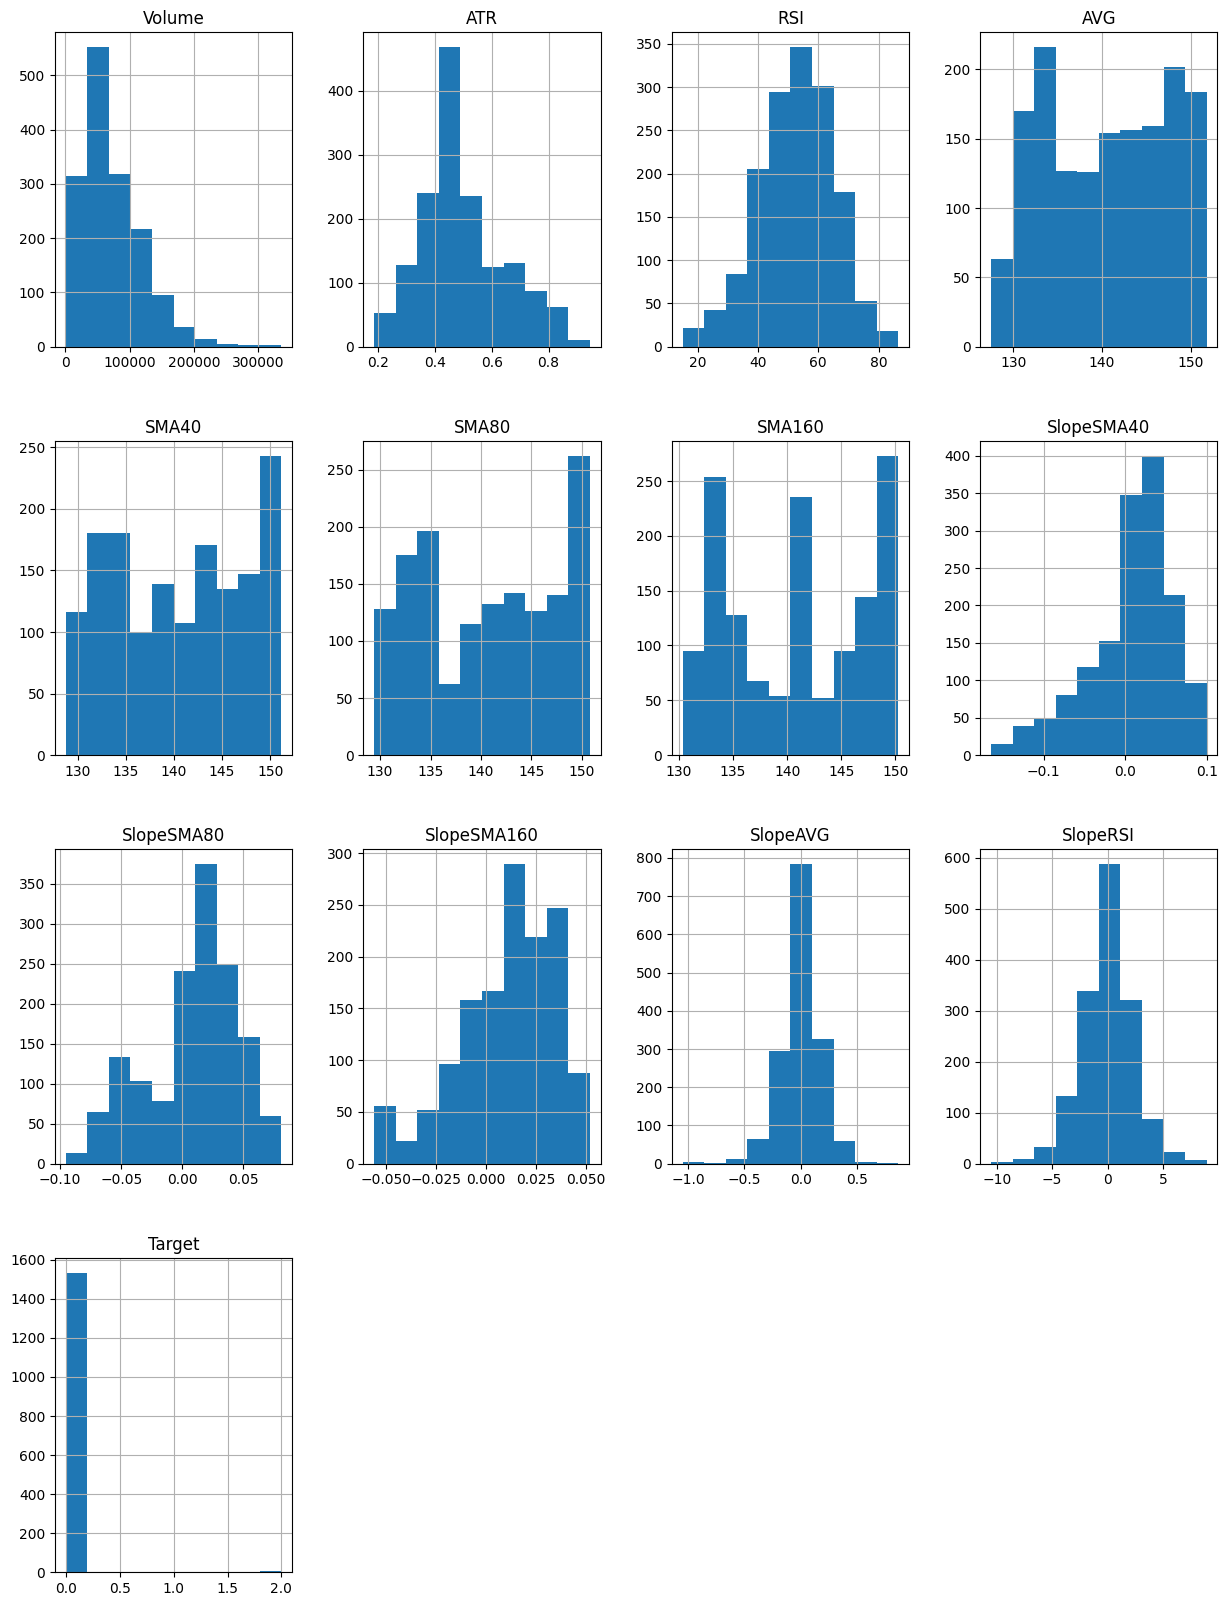

In [11]:
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(15,20))
ax = figure.gca()
data_model = data[["Volume", "ATR", "RSI", "AVG", "SMA40", "SMA80", "SMA160", "SlopeSMA40", "SlopeSMA80", "SlopeSMA160", "SlopeAVG", "SlopeRSI", "Target"]]
data_model.hist(ax=ax)
plt.show()

### RSI as a Trend Indicator

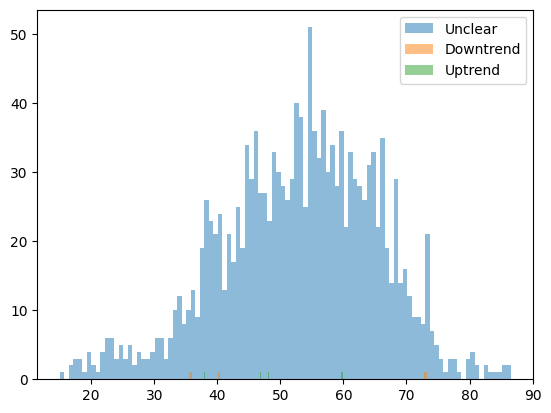

In [12]:
from matplotlib import pyplot
data_up = data.RSI[data["Target"] == 2]
data_down = data.RSI[data["Target"] == 1]
data_unclear = data.RSI[data["Target"] == 0]
pyplot.hist(data_unclear, bins=100, alpha=0.5, label="Unclear")
pyplot.hist(data_down, bins=100, alpha=0.5, label="Downtrend")
pyplot.hist(data_up, bins=100, alpha=0.5, label="Uptrend")

pyplot.legend(loc="upper right")
pyplot.show()

### TBC After Exams